<a href="https://colab.research.google.com/github/kkb0318/benkyokai/blob/main/bayesLinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ライブラリインポート

In [1]:
!pip install arviz==0.10.0
!pip install --upgrade pymc3==3.8

     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 768kB 16.6MB/s 
     |████████████████████████████████| 4.7MB 21.3MB/s 
     |████████████████████████████████| 317kB 32.1MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
     |████████████████████████████████| 911kB 4.2MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [2]:
import sys
print('Running on Python v{}'.format(sys.version))
import numpy as np
print('Running on numpy v{}'.format(np.__version__))
import matplotlib
print('Running on matplotlib v{}'.format(matplotlib.__version__))
import pymc3 as pm
print('Running on pymc3 v{}'.format(pm.__version__))
import arviz as az
print('Running on arviz v{}'.format(az.__version__))
import matplotlib.pyplot as plt
np.random.seed(seed=10)

Running on Python v3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
Running on numpy v1.19.5
Running on matplotlib v3.2.2
Running on pymc3 v3.8
Running on arviz v0.10.0


## データ

### お試し学習用データの作成
* データはsin関数+ノイズにより取得
* 今回はお試しとしてこちらで定義した関数から観測データが得られるとし、そのデータをもとに学習を行う

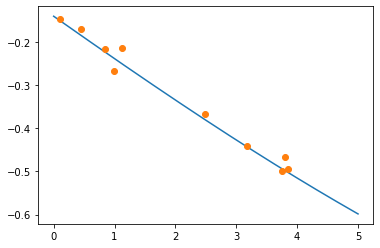

In [3]:
'''
真の関数(グラフの青線)
データはこの関数から生成されているとする
ただし分析者はこの真の関数を知らないとする
'''
def true_func(x, params={'A':1,'omega':.1,'t':3}):
    y = params['A'] * np.sin(x * params['omega'] - params['t'])
    return y

'''
観測データを生成する関数（グラフのオレンジのプロット）
真の関数にノイズの入ったデータが得られると仮定
'''
def data_model(x, mu=0,var=0.03):
    y = true_func(x)
    noise = np.random.normal(mu, var)
    return y + noise

xmin,xmax = 0, 5

# 観測データ
x_sample = xmin + (xmax-xmin)*np.random.rand(10) # xをランダムに指定
y_sample = list(map(lambda x:data_model(x), x_sample))
# 真の関数描画用のデータ
true_x_sapmle = np.linspace(xmin, xmax, 1000)
true_y_sapmle = list(map(lambda x:true_func(x), true_x_sapmle))

# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

ax.plot(true_x_sapmle, true_y_sapmle, '-')
ax.plot(x_sample, y_sample, 'o')

## 学習

### 線形回帰

In [4]:
with pm.Model() as linear:
    # 事前分布
    sigma = pm.HalfCauchy("sigma", beta=10)
    intercept = pm.Normal("b", 0, sigma=20)
    x_coeff = pm.Normal("a", 0, sigma=20)

    # 尤度関数
    likelihood = pm.Normal("y", mu=intercept + x_coeff * x_sample, sigma=sigma, observed=y_sample)

    # 事後分布
    trace_linear = pm.sample(3000, cores=2)  # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:10<00:00, 678.61draws/s]


## 推論・可視化

In [5]:
# 推論
ppc = pm.sample_posterior_predictive(trace_linear,model=linear)

100%|██████████| 6000/6000 [00:10<00:00, 553.34it/s]


/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


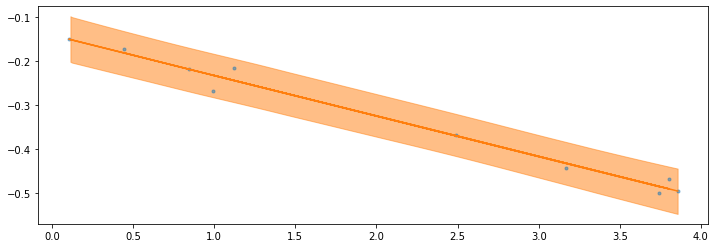

In [6]:
'''
 推論結果の可視化
 オレンジ線：推論の平均値
 オレンジ領域：HDI(95%信頼区間)
 青点：データ
'''
_, ax = plt.subplots(1, 1, figsize=(12, 4))
mu_bar = np.mean(ppc['y'],axis=0)
mu_p = ppc["y"]
ax.plot(x_sample, y_sample, '.',alpha=0.5)
ax.plot(x_sample, mu_bar)
pm.plot_hdi(x_sample, y=mu_p,ax=ax)
plt.show()

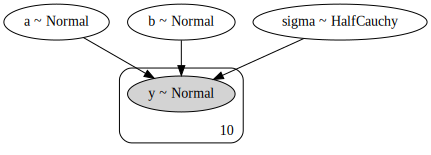

In [7]:
# ベイジアンネットワーク
pm.model_to_graphviz(linear)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 504x504 with 0 Axes>

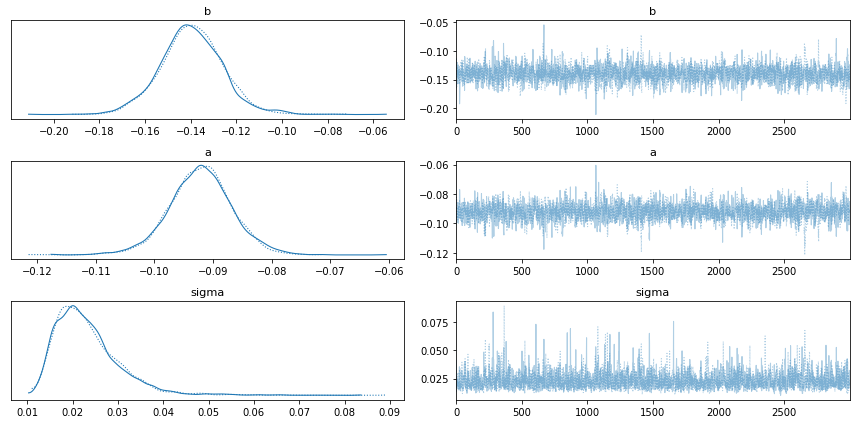

In [8]:
# MCMC
plt.figure(figsize=(7, 7))
pm.traceplot(trace_linear)
plt.tight_layout();

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8617550d90>,
      dtype=object)

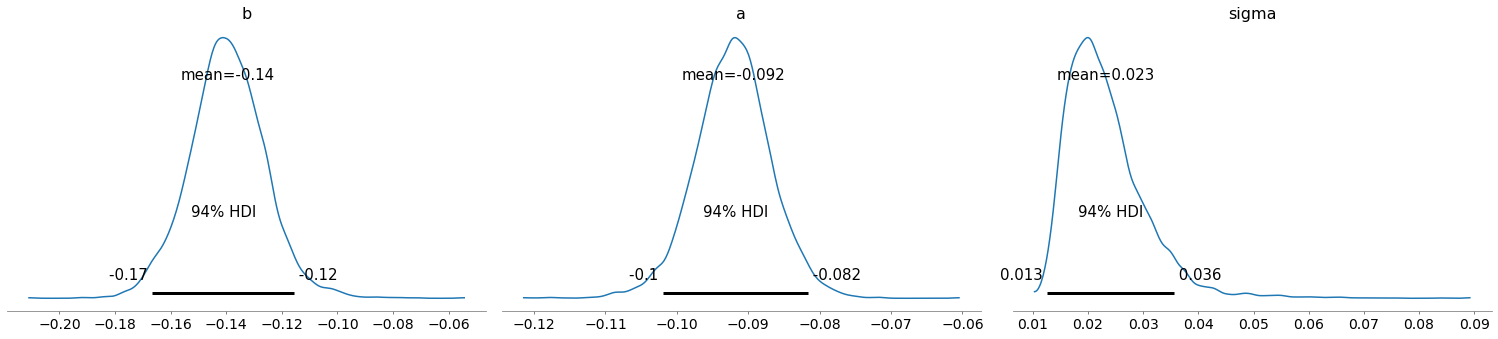

In [9]:
# 事後分布の可視化
pm.plot_posterior(trace_linear)